# Wood Veneer Color Analysis AI Model
This notebook processes wood veneer images, extracts color features, and predicts their position on a predefined color spectrum using real data.

## Step 1: Import Required Libraries

In [16]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
    

## Step 2: Image Preprocessing

In [17]:

def extract_lab_features(image_path):
    """Extract L*, a*, b* mean values from an image."""
    image = cv2.imread(image_path)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_mean = np.mean(lab[:,:,0])  # Lightness (L*) component
    a_mean = np.mean(lab[:,:,1])  # Red-Green component
    b_mean = np.mean(lab[:,:,2])  # Blue-Yellow component
    return l_mean, a_mean, b_mean
    

## Step 3: Load Dataset and Extract Features

In [18]:

dataset_path = "/Users/rishimanimaran/Documents/College/junior-year/fall-2024/cs-3311/JDA-4307-Color-Verification/Images/Walnut/3062 - Graphite Walnut"  # Update this to your dataset folder

# Collect data
data = []
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(dataset_path, filename)
        l_mean, a_mean, b_mean = extract_lab_features(image_path)
        data.append([image_path, l_mean, a_mean, b_mean, 0.0])  # 0.0 = Ideal (Just Right)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["image_path", "L*", "a*", "b*", "position_score"])
df.to_csv("real_veneer_dataset.csv", index=False)
print("Dataset saved! Total samples:", len(df))
    

KeyboardInterrupt: 

## Step 4: Augment Data with Darker and Lighter Samples

In [ ]:

def adjust_lightness(image_path, factor):
    """Increase or decrease lightness (L*) to create synthetic darker/lighter samples."""
    image = cv2.imread(image_path)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Scale L* values
    l = np.clip(l * factor, 0, 255).astype(np.uint8)

    # Merge channels back
    adjusted_lab = cv2.merge((l, a, b))
    adjusted_image = cv2.cvtColor(adjusted_lab, cv2.COLOR_LAB2BGR)
    
    return adjusted_image

# Create synthetic darker and lighter images
augmented_data = []
for index, row in df.iterrows():
    image_path, l_mean, a_mean, b_mean = row["image_path"], row["L*"], row["a*"], row["b*"]
    
    # Darker sample (Too Dark)
    dark_img = adjust_lightness(image_path, 0.8)
    dark_path = image_path.replace(".jpg", "_dark.jpg")
    cv2.imwrite(dark_path, dark_img)
    augmented_data.append([dark_path, l_mean * 0.8, a_mean, b_mean, -1.0])  # -1 = Too Dark
    
    # Lighter sample (Too Light)
    light_img = adjust_lightness(image_path, 1.2)
    light_path = image_path.replace(".jpg", "_light.jpg")
    cv2.imwrite(light_path, light_img)
    augmented_data.append([light_path, l_mean * 1.2, a_mean, b_mean, 1.0])  # 1 = Too Light

# Add synthetic samples to dataset
augmented_df = pd.DataFrame(augmented_data, columns=["image_path", "L*", "a*", "b*", "position_score"])
df = pd.concat([df, augmented_df])

df.to_csv("augmented_veneer_dataset.csv", index=False)
print("Augmented dataset saved! Total samples:", len(df))
    

Augmented dataset saved! Total samples: 1251


## Step 5: Train the AI Model on Real Data

In [ ]:

df = pd.read_csv("augmented_veneer_dataset.csv")

# Extract features and target
X = df[["L*", "a*", "b*"]]
y = df["position_score"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained on real veneer data!")
    

Model trained on real veneer data!


## Step 6: Predict Position of a New Sample

In [24]:

def predict_position(image_path, model):
    """Predict where a veneer sample falls on the color spectrum."""
    l_mean, a_mean, b_mean = extract_lab_features(image_path)
    position = model.predict([[l_mean, a_mean, b_mean]])[0]
    return position

image_path = "/Users/rishimanimaran/Downloads/IMG_3281.JPG"  # Replace with a new image
position_score = predict_position(image_path, model)

print(f"📌 Sample falls at position: {position_score:.2f} (-1 = Dark, 0 = Ideal, 1 = Light)")
    

📌 Sample falls at position: -0.74 (-1 = Dark, 0 = Ideal, 1 = Light)


/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Step 7: Compute Confidence Score

In [7]:

def compute_confidence_score(position_score):
    """Convert position score to a confidence percentage (0-100%)."""
    return 100 * (1 - abs(position_score))

confidence = compute_confidence_score(position_score)
print(f"🎯 Confidence: {confidence:.2f}% match to ideal medium cherry.")
    

🎯 Confidence: 68.00% match to ideal medium cherry.


## Step 8: Visualize Sample Position on the Spectrum

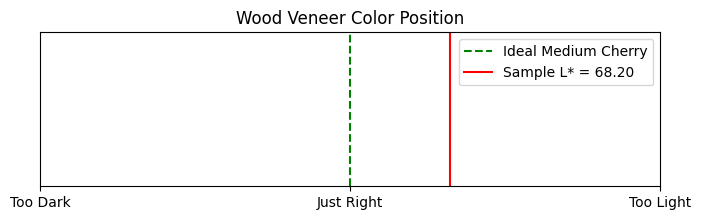

In [ ]:

def plot_color_match(sample_L, ideal_L=65, dark_threshold=55, light_threshold=75):
    """
    Visualizes where the sample falls on the Too Dark → Just Right → Too Light spectrum.
    """
    plt.figure(figsize=(8, 2))
    plt.axvline(ideal_L, color='green', linestyle='--', label="Ideal Medium Cherry")
    plt.axvline(sample_L, color='red', linestyle='-', label=f"Sample L* = {sample_L:.2f}")

    plt.xticks([dark_threshold, ideal_L, light_threshold], ["Too Dark", "Just Right", "Too Light"])
    plt.yticks([])
    plt.legend()
    plt.title("Wood Veneer Color Position")
    plt.show()

plot_color_match(position_score * 10 + 65)
    

In [10]:
# Folder containing images to analyze
image_folder = "/Users/rishimanimaran/Documents/College/junior-year/fall-2024/cs-3311/JDA-4307-Color-Verification/Images/Cherry/3422 - Medium Cherry"  # Update this path

# Store similarity scores
image_scores = []

for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)
        
        # Predict similarity score
        position_score = predict_position(image_path, model)
        confidence = compute_confidence_score(position_score)
        
        # Store results
        image_scores.append([image_path, position_score, confidence])

# Convert results into a DataFrame
results_df = pd.DataFrame(image_scores, columns=["image_path", "position_score", "confidence_score"])

# Save results for later analysis
results_df.to_csv("image_similarity_scores.csv", index=False)
print(f"Processed {len(results_df)} images and saved similarity scores!")


/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/ap

Processed 973 images and saved similarity scores!


/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Folder containing images to analyze
image_folder = "/Users/rishimanimaran/Documents/College/junior-year/fall-2024/cs-3311/JDA-4307-Color-Verification/Images/Cherry/3422 - Medium Cherry"

# Store similarity scores
image_scores = []

for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)
        
        # Predict similarity score
        position_score = predict_position(image_path, model)
        confidence = compute_confidence_score(position_score)
        
        # Store results
        image_scores.append([image_path, position_score, confidence])

# Convert results into a DataFrame
results_df = pd.DataFrame(image_scores, columns=["image_path", "position_score", "confidence_score"])

# Save results for later analysis
results_df.to_csv("image_similarity_scores.csv", index=False)
print(f"Processed {len(results_df)} images and saved similarity scores!")



/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rishimanimaran/miniforge3/envs/ap

Processed 973 images and saved similarity scores!


/Users/rishimanimaran/miniforge3/envs/apple_tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [28]:
import matplotlib.pyplot as plt

def plot_color_match_all_samples(results_df, ideal_L=65, dark_threshold=55, light_threshold=75):
    """
    Visualizes where all samples fall on the Too Dark → Just Right → Too Light spectrum.

    Args:å
        results_df (pd.DataFrame): DataFrame containing image paths and position scores.
        ideal_L (float): The L* value of the ideal veneer sample.
        dark_threshold (float): The lower bound of acceptable range.
        light_threshold (float): The upper bound of acceptable range.
    """
    plt.figure(figsize=(10, 2))

    # Plot ideal veneer as a reference line
    plt.axvline(ideal_L, color='green', linestyle='--', label="Ideal Medium Cherry")

    # Plot each sample on the spectrum
    for _, row in results_df.iterrows():
        sample_L = row["position_score"] * 10 + 65  # Adjust scaling if necessary
        plt.axvline(sample_L, color='red', linestyle='-', alpha=0.5)

    # Configure x-axis labels
    plt.xticks([dark_threshold, ideal_L, light_threshold], ["Too Dark", "Just Right", "Too Light"])
    plt.yticks([])
    plt.legend()
    plt.title("Wood Veneer Color Positions - All Samples")
    plt.show()


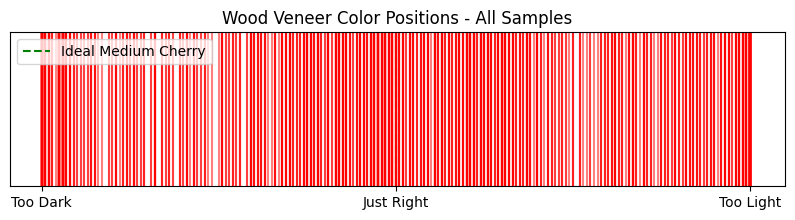

In [29]:
plot_color_match_all_samples(results_df)


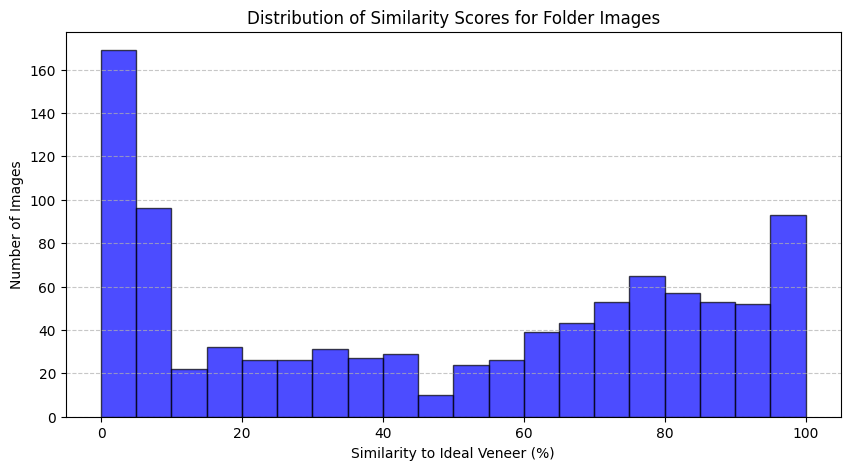

In [11]:
# Plot histogram of similarity scores
plt.figure(figsize=(10, 5))
plt.hist(results_df["confidence_score"], bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Similarity to Ideal Veneer (%)")
plt.ylabel("Number of Images")
plt.title("Distribution of Similarity Scores for Folder Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [27]:
import joblib

# Save the trained model
model_filename = "medium_cherry_regression_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")


Model saved as medium_cherry_regression_model.pkl
